# Summary

The following is an LSTM built to generate text. It is trained on the bible. It progressively <br>learns to generate language like structures (correct spacing), with mostly English words, <br>but the output remains nonsensical even after longer training.

**Overview of model:**
- Embedding dimension of 128
- 2 LSTM layers
- Dropout of 0.25 
- Hidden dimension of 512
- Batch size of 32
- ADAM optimizer 
    - Learning rate of 0.001
- BCE loss

**Possible future improvements:** 
- Randomizing input during training
- Tweaking hyperparameters 
    - Sequence length 
    - Number of lstm layers 
    - Dropout rate
    - Number of epochs
    - etc.


# Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Data

In [2]:
# The bible from https://www.kaggle.com/phyred23/bibleverses
data = pd.read_csv("data/bible_data.csv")

In [3]:
data.head()

,citation,book,chapter,verse,text
0,Genesis 1:1,Genesis,1,1,In the beginning God created the heaven and th...
1,Genesis 1:2,Genesis,1,2,"And the earth was without form, and void; and ..."
2,Genesis 1:3,Genesis,1,3,"And God said, Let there be light: and there wa..."
3,Genesis 1:4,Genesis,1,4,"And God saw the light, that it was good: and G..."
4,Genesis 1:5,Genesis,1,5,"And God called the light Day, and the darkness..."


In [4]:
# Getting all unique symbols from data and prepping data
symbols = set()
training_data = ""

for verse in data["text"]:
    # case insensitive
    verse = verse.lower()
    # line insensitive
    verse = verse.replace(" \n", "")
    verse = verse.replace("\n", "")
    verse = verse.strip()
    verse = verse + " "
    training_data += verse 
    
for char in training_data:
     symbols.add(char)

In [5]:
# Building the dictionaries for character to index (vocab) 
# and index to character (idx_to_char)
vocab = dict()

for symbol in sorted(list(symbols)):
    vocab[symbol] = len(vocab)
    
idx_to_char = {v: k for k, v in vocab.items()}

# Parameters

In [6]:
# Length of sequence used to train the model
IN_SEQ_LEN = 64
# Length of sequence to be generated
OUT_SEQ_LEN = 100
# GREED is a measure for how 'greedy' the model is when 
# generating characters. Used to create a threshold for 
# sigmoid output by multiplying by max of that output.
# Character is then chosen randomly from all characters 
# that exceed the threshold. For instance, if "t" has the
# highest sigmoid activation at 0.8 and GREED is set to 
# 0.8, then the character is chosen randomly (uniform) from 
# all characters that have an activation of at least 0.64.
# First number corresponds to greediness when the last
# character was a space (" "), second number corresponds
# to all other cases. This increases diversity of output.
# The first number should be smaller than the second to
# increase diversity of words generated while keeping 
# consistency within words.
GREED = (0.5, 0.8)
BATCH_SIZE = 32
# Length of data for training loop
DATA_LEN = len(training_data)
LEARNING_RATE = 0.001
EPOCHS = 1
# Set USE_CUDE to True when running on GPU.
USE_CUDA = False

# Model

In [7]:
class LSTM(nn.Module):
    """
    LSTM model for character level text generation
    """
    def __init__(
        self, 
        vocab=vocab, 
        input_len=IN_SEQ_LEN, 
        batch_size=BATCH_SIZE,
        embedding_dim=128, 
        hidden_dim=512, 
        lstm_layers=2, 
        bidirectional=False
    ):
        super(LSTM, self).__init__()
        self.input_len = input_len
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.bidir_adjust = 2 if bidirectional else 1
        self.output_dim = len(vocab)
        
        self.embed = nn.Embedding(
            len(vocab)+1, 
            embedding_dim
        )
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            lstm_layers, 
            bidirectional=bidirectional
        )
        
        self.dropout = nn.Dropout(p=0.25)
        
        self.hidden = torch.zeros(
            lstm_layers, 
            batch_size, 
            hidden_dim
        )
        
        self.cellstate = torch.zeros(
            lstm_layers, 
            batch_size, 
            hidden_dim
        )
        
        self.linear = nn.Linear(
            self.bidir_adjust*hidden_dim*input_len, 
            self.output_dim*self.batch_size
        )
        
        self.out = nn.Sigmoid()
        
    def reset_cell(self):
        self.hidden = torch.zeros(
            self.lstm_layers, 
            self.batch_size, 
            self.hidden_dim
        )
        
        self.cellstate = torch.zeros(
            self.lstm_layers, 
            self.batch_size, 
            self.hidden_dim
        )
        
    def forward(self, x):
        x = self.embed(x)
        x, (self.hidden, self.cellstate) = self.lstm(x)
        x = self.dropout(x)
        x = self.linear(x.view(self.batch_size, -1))
        x = self.out(x[-1].view(
            self.batch_size, 
            self.output_dim
        ))
        return x

In [8]:
# Initializing model, loss function, and optimizer
lstm = LSTM()
if USE_CUDA and torch.cuda.is_available():
    lstm.cuda()
# Binary cross entropy loss because the lstm is a classification
# model that assigns each character with a probability that it
# comes next (correct character = 1, all other characters = 0)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(
    lstm.parameters(), 
    lr=LEARNING_RATE
)

# Training

In [9]:
loss_dict = dict()

for e in range(EPOCHS):
    print("------ EPOCH {} OF {} ------".format(e+1, EPOCHS))
    
    # Reset cell at the beginning of each epoch
    lstm.reset_cell()
    
    # Looping over the data in batches
    for i in range(0, DATA_LEN, BATCH_SIZE):
        
        if i % 50000 == 0:
            print(i/float(DATA_LEN))
        
        optimizer.zero_grad()
        
        # Vector of input character sequences
        input_vector = torch.tensor([[
            vocab.get(char, len(vocab)) 
            for char in training_data[i+b:i+b+IN_SEQ_LEN]
        ] for b in range(BATCH_SIZE)])
        
        if USE_CUDA and torch.cuda.is_available():
            input_vector = input_vector.cuda()
        
        output_vector = lstm(input_vector)      
        
        # Creating target vector by looking at the consequent 
        # characters
        target_vector = torch.zeros(output_vector.shape)
        for b in range(BATCH_SIZE):
            target_vector[b][vocab.get(
                training_data[i+b+IN_SEQ_LEN]
            )] = 1
            
        if USE_CUDA and torch.cuda.is_available():
            target_vector = target_vector.cuda()
        
        # Calculating loss and backpropagating
        error = loss(output_vector, target_vector)
        
        error.backward()
        optimizer.step()
        
        loss_dict[(e, int(i/BATCH_SIZE))] = error.item()

------ EPOCH 1 OF 1 ------
0.0


# Results

In [10]:
def plot_loss(epoch=0):
    losses = [
        loss_dict[(epoch, x)] 
        for x in range(int(DATA_LEN/BATCH_SIZE))
    ]
    plt.plot(list(range(len(losses))), losses)
    plt.title("Loss per batch in epoch {}".format(epoch+1))
    plt.xlabel("Batch")
    plt.ylabel("Binary cross-entropy loss")

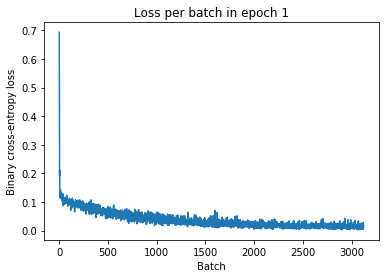

In [11]:
# Loss of the model trained on 100,000 characters
plot_loss()

# Examples

In [12]:
def get_example(model):
    """
    Takes a model and returns a random sequence of length 
    IN_SEQ_LEN from the bible (in_seq), a sequence of length 
    OUT_SEQ_LEN generated by the model (out_seq), and the two 
    sequences together (full_seq).
    """
    # Getting random sequence from bible
    seq_start = np.random.randint(
        0, len(training_data)-IN_SEQ_LEN
    )
    in_seq = training_data[
        seq_start:seq_start+IN_SEQ_LEN+BATCH_SIZE-1
    ]
    out_seq = ""
    full_seq = in_seq
    
    # Resetting cell state
    model.reset_cell()
    
    # Initializing greediness depending on last character 
    # of input
    G = GREED[0] if in_seq[-1] == " " else GREED[1]
    
    # Looping over the number of characters to be generated
    for i in range(OUT_SEQ_LEN):

        # Getting input vector
        current_in = torch.tensor([[
            vocab.get(char, len(vocab)) 
            for char in full_seq[i+b:i+b+IN_SEQ_LEN]
        ] for b in range(BATCH_SIZE)])

        if USE_CUDA and torch.cuda.is_available():
            current_in = current_in.cuda()

        current_out = model(current_in)
        
        # Getting options for next character based on 
        # greediness
        options = [[] for b in range(BATCH_SIZE)]
        option_idx = (
            current_out >= G*current_out.max(
                1, keepdim=True)[0]).nonzero()
        
        for j, k in option_idx:
            options[j].append(k)
        
        # Selecting the next character from options
        out_char = "".join([idx_to_char[o.item()] 
                            for o in [np.random.choice(l) 
                                for l in options]])[-1]
        
        # Updating greediness based on new last character
        G = GREED[0] if out_char == " " else GREED[1]
        
        # Updating sequences
        out_seq += out_char
        full_seq += out_char

    return full_seq, in_seq, out_seq

### LSTM after training on 0 characters

Model output is fully random.

In [25]:
lstm0 = LSTM()
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [26]:
_, in_seq, out_seq = get_example(lstm0)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: ey took up of the fragments that remained twelve baskets full. and they that had eaten were abo
OUTPUT: da-:!|'ko!wwk)n;d|!bbif?dl  'f-vy,|a|hu| !bb-ulbkuopvq)r't:h|r!bos.w!jzihka);ap.cmjf,uvbeowzbez'bnm.


### LSTM after training on 100 characters

Model outputs the same character over and over.

In [23]:
lstm100 = torch.load(
    "models/lstm100char", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [24]:
_, in_seq, out_seq = get_example(lstm100)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: ll cast thee as profane out of the mountain of god: and i will destroy thee, o covering cherub,
OUTPUT: ;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;


### LSTM after training on 1,000 characters

Model starts learning about spacing, but only uses one other character.

In [21]:
lstm1000 = torch.load(
    "models/lstm1000char", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [22]:
_, in_seq, out_seq = get_example(lstm1000)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: ntiles, i magnify mine office: if by any means i may provoke to emulation them which are my fle
OUTPUT:  a a a   a   a   a   a a  a a  a a      a  a       a    a a   a  a    a a   a a  a  a a a  a    a  a


### LSTM after training on 10,000 characters

Model puts together characters and separates them with spaces. No actual words yet.

In [19]:
lstm10000 = torch.load(
    "models/lstm10000char", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [20]:
_, in_seq, out_seq = get_example(lstm10000)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: oshua: for i will utterly put out the remembrance of amalek from under heaven. and moses built 
OUTPUT: edsesio hh e anto nrl ehl ton neldlddl nn t a andr  ee eoet t  l odd o e  eat e lrw sm d don tssd ll


### LSTM after training on 100,000 characters

Model uses some real words, like "the" and "them". Spacing improves.

In [15]:
lstm100000 = torch.load(
    "models/lstm100000char", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [16]:
_, in_seq, out_seq = get_example(lstm100000)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT:  whose end is to be burned. but, beloved, we are persuaded better things of you, and things tha
OUTPUT: themed o e ho the cel tot ald hta te tha thely the them ald flet ahd the thwl  wot  and th ssd ns an


### LSTM after training on full data (>4M characters)

Mostly English words, correct spacing (i.e. no double space). Somewhat grammatical but mostly nonsensical.

In [38]:
lstm1 = torch.load(
    "models/lstm1", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [39]:
_, in_seq, out_seq = get_example(lstm1)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: ll they die. at the mouth of two witnesses, or three witnesses, shall he that is worthy of deat
OUTPUT: h his son son all he weal his said with son the saying, and the senter so was came not as the come o


### LSTM after training for two epochs on full data (2x >4M characters)

Not much changes when adding a second epoch - the output suffers from similar insufficiencies.

In [40]:
lstm2 = torch.load(
    "models/lstm2", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [43]:
_, in_seq, out_seq = get_example(lstm2)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: d the kingdom, and had strengthened himself, he forsook the law of the lord, and all israel wit
OUTPUT: h the house house and with unto the llren for the have were him him the with the med and stered him 


### LSTM after training for three epochs on full data (3x >4M characters)

In [46]:
lstm3 = torch.load(
    "models/lstm3", 
    map_location='cpu'
)
lstm.eval()

LSTM(
  (embed): Embedding(39, 128)
  (lstm): LSTM(128, 512, num_layers=2)
  (dropout): Dropout(p=0.25)
  (linear): Linear(in_features=32768, out_features=1216, bias=True)
  (out): Sigmoid()
)

In [48]:
_, in_seq, out_seq = get_example(lstm3)
print("INPUT: {}".format(in_seq))
print("OUTPUT: {}".format(out_seq))

INPUT: n they journeyed: whether it was by day or by night that the cloud was taken up, they journeyed
OUTPUT:  and not the him the saled have god and the said unto the unto the hear and the shall be a the bread
